# <center> ⚡ Lightning практика 🛠

В этом шаге предлагаем вам попрактиковаться в переносе кода обучения нейросети с `PyTorch` на `PyTorch Lightning`.

Вам дан ноутбук с обучением простой свёрточной нейросети, реализованной на чистом `PyTorch`, которую необходимо перенести на `PyTorch Ligthning` и обучить её с помощью `Trainer`, выполнив все условия.

Вам необходимо сдать файл с расширением любое_имя.py в котором:

**Основное задание (5 баллов):**

* Будет загрузка датасета
* Создание `LightningDataModule`
* Создание `LightningModule`
* Обучение модели с помощью `Trainer`  и сохранение её весов
* Запуск инференса модели на одном образце из теста

**Дополнительное задание (2 балла):**

* Добавьте считывание параметра `--fast_dev_run` при запуске файла на исполнение, который будет отвечать за проверочный прогон сетки на 1 эпохе (значение по умолчанию `False`).
* В случае успеха выводить в консоль сообщение: `"Тестовый прогон успешно пройден"`. Далее работа скрипта продолжается в обычном режиме.
* В случае неудачи выводить в консоль сообщение: `"Тестовый прогон завершился с ошибкой"`. После чего дальнейшая работа скрипта должна завершиться.
  
Пример команды: `python любое_имя.py --fast_dev_run True`
  
Файл должен запускаться командой `python любое_имя.py` и отрабатывать до конца без падений.

<div class="alert alert-warning">

<p style="text-align: center;"> ВАЖНО! 👺 </p>

Если на каком-то ресурсе вы видите `pip install pytorch-lightning` - значит вы собираетесь использовать старое API 😯! Функции обратно совместимы, но их импорт может отличаться - будьте аккуратны и устанавливайте только свежие версии библиотек.

In [35]:
# Установка Pytorch Lightning
!pip install lightning -q


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd

In [2]:
import time
import os
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Загружаем датасет Sign Language MNIST

Датасет представляет из себя 2 CSV файла - трэйн и тест сплиты. 
Каждая запись представляет из себя: 
* метку (номер буквы в алфавите)
* значения каждого из 780 пикселей изображения.
<img src="../data/amer_sign2.png"/>

In [4]:
%%capture
# Для запуска в колаб
# !mkdir ../data/
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/sign_mnist_train.csv.zip
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/sign_mnist_test.csv.zip
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/amer_sign2.png
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/amer_sign3.png
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/american_sign_language.PNG

!unzip ../data/sign_mnist_train.csv.zip -d ../data/
!unzip ../data/sign_mnist_test.csv.zip -d ../data/

In [5]:
train = pd.read_csv('../data/sign_mnist_train.csv')
test = pd.read_csv('../data/sign_mnist_test.csv')

In [6]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
test.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222


## Определяем Pytorch Dataset and Dataloader:



In [8]:
# class SignLanguageDataset(data.Dataset):
    
#     def __init__(self, df, transform=None):
        
#         self.df = df
#         self.transform = transform
        
#     def __len__(self):
#         return self.df.shape[0]
    
#     def __getitem__(self, index):
        
#         label = self.df.iloc[index, 0]
        
#         img = self.df.iloc[index, 1:].values.reshape(28, 28)
#         img = torch.Tensor(img).unsqueeze(0)
#         if self.transform is not None:
#             img =self.transform(img)
        
#         return img, label
        

In [9]:
# transforms4train = transforms.Compose([
#         #transforms.Normalize(159, 40),
#         transforms.RandomHorizontalFlip(p=0.1),
#         transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
# ]) 

In [10]:
# train_dataset = SignLanguageDataset(train, transform=transforms4train)
# test_dataset = SignLanguageDataset(test)

In [12]:
class SignLanguageDataset(data.Dataset):
    transforms4train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
    ])
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        label = self.df.iloc[index, 0]
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [13]:
train_dataset = SignLanguageDataset(train, transform=SignLanguageDataset.transforms4train)
test_dataset = SignLanguageDataset(test)

In [14]:
len(train_dataset), len(test_dataset)

(27455, 7172)

__Windows Multiprocessing Limitation:__

Windows uses spawn instead of fork for multiprocessing, which means child processes cannot inherit the Jupyter notebook's memory state.
В jupyter используется spawn, 
Use Linux/WSL These systems use fork for multiprocessing, which works seamlessly with Jupyter notebook.

__Fix:__
 
 num_workers=0, disables multiprocessing entirely, forcing data loading to happen in the main process. This avoids the pickling error because no subprocesses are spawned.

In [15]:
train_loader = data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=0)
test_loader = data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=0)

### Посмотрим как выглядит одно изображение из трэйна

In [16]:
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

In [17]:
trainiter = iter(train_loader)
img, label = next(trainiter)
print(img.shape)

torch.Size([200, 1, 28, 28])


tensor(11)


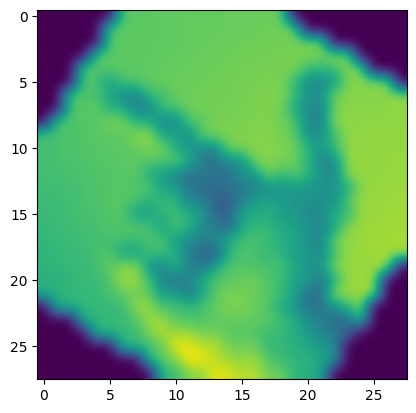

In [18]:
show_img(img[0], label[0])

In [19]:
def calc_out_size(img_size, kernel_size, stride=1, padding=1, dilation=1 ):
    out_size = ((img_size + 2 * padding - (dilation * (kernel_size - 1) + 1 )) / stride) + 1
    return int(out_size)

In [20]:
calc_out_size(28, 3)

28

## Напишем простую сверточную нейросеть и обучим её:

In [21]:
class MyConvNet(nn.Module):
    
    def __init__(self, stride=1, dilation=1, n_classes=25):
        
        super(MyConvNet, self).__init__()
        
        self.stride = stride
        self.dilation = dilation
        self.n_classes = n_classes
        
        self.block1 = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
        )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
    
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x

In [22]:
model = MyConvNet()
model

MyConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=100, out_features=25, bias=True)
)

In [23]:
# Проверяем
sample_batch = torch.ones(20, 1, 28, 28)
print(model.block1(sample_batch).shape)
print(model.block2(model.block1(sample_batch)).shape)
print(model(sample_batch).shape)

torch.Size([20, 8, 14, 14])
torch.Size([20, 16, 7, 7])
torch.Size([20, 25])


## Напишем циклы тренировки и валидации модели:

In [24]:
def eval_model(model, criterion, test_loader, cuda=True):
    model = model.to(device)
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels in test_loader:
        batch = batch.to(device)
        labels = labels.to(device)
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy

In [25]:
def train_model(n_epochs, model, optimizer, criterion, train_loader, test_loader, cuda=True):
    model = model.to(device)
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_loader:
            batch = batch.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
              
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=True)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc        
        
        

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [27]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, model, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (12.8727 s.): train loss - 0.01066883560270071, train accuracy - 0.3884174103077764; test loss - 0.004910214804112911, test accuracy - 0.7177914110429447
EPOCH 1 (12.663 s.): train loss - 0.004750770982354879, train accuracy - 0.7273720633764341; test loss - 0.0025544888339936733, test accuracy - 0.8296151701059676
EPOCH 2 (12.8273 s.): train loss - 0.0031360348220914602, train accuracy - 0.8197778182480423; test loss - 0.0019011014373973012, test accuracy - 0.8774400446179588
EPOCH 3 (12.9578 s.): train loss - 0.0024980863090604544, train accuracy - 0.8520123839009288; test loss - 0.002050296636298299, test accuracy - 0.878276631344116
EPOCH 4 (14.4278 s.): train loss - 0.002119269920513034, train accuracy - 0.8712074303405573; test loss - 0.002296113409101963, test accuracy - 0.8660066926938093
EPOCH 5 (14.3098 s.): train loss - 0.001971917925402522, train accuracy - 0.8782735385175742; test loss - 0.0017439844086766243, test accuracy - 0.8873396542108198
EPOCH 6 (14.5442 s.)

Text(0.5, 1.0, 'Accuracy')

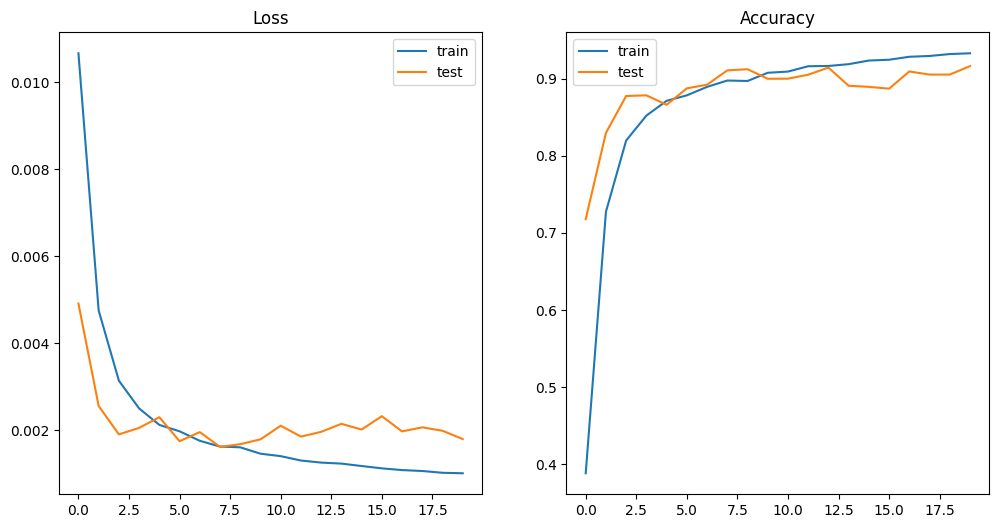

In [28]:
# Посмотрим прогресс обучения на графиках
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [29]:
# Сохраним модель
state = {'model': model.state_dict(),
        'epoch': 20}

model_path = Path('../models')
model_name = 'myconvnet_sign_lang.pth'
model_path.mkdir(parents=True, exist_ok=True) # Создаем папку, если ее не существует

torch.save(state, model_path / model_name)

## Посмотрим как модель предсказывает

In [30]:
testiter = iter(test_loader)
img, label = next(testiter)
model = model.cpu()

Fact: 7, Prediction: 7
tensor(7)


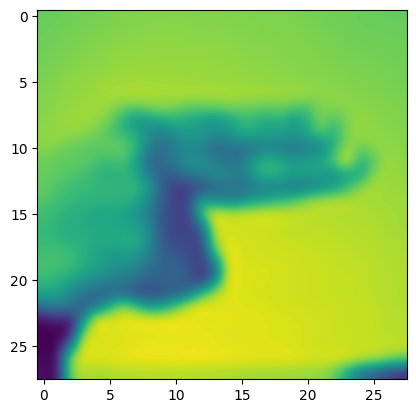

In [31]:
idx=12
pred = model(img)
print(f'Fact: {label[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')
show_img(img[idx], label[idx])

### Запись файла для сдачи на Stepik

In [2]:
%%writefile homework02.py
#!/usr/bin/env python
import argparse
from io import BytesIO
from zipfile import ZipFile
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict, Any
import torch.utils.data as data
import os

import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import lightning as pl
from lightning import Trainer, LightningModule, LightningDataModule# Джентельменский наборчик
from lightning.pytorch.callbacks import  ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# your code here
@dataclass
class CFG:
    seed: int = 2025
    accelerator: str = "auto"  # Автоматическое определение
    devices: int = 1
    dropout: float = 0.3
    lr: float = 1e-3
    batch_size: int = 200
    test_size: float = 0.2
    num_workers: int = min(2, os.cpu_count())
    epochs: int = 10
    gpus: int = 2
    stride: int = 1
    dilation: int =1
    n_classes: int =25
        
    def __post_init__(self):
        pl.seed_everything(self.seed)
        # Автоматическое определение доступных устройств
        if torch.cuda.is_available():
            self.accelerator = "gpu"
            self.devices = torch.cuda.device_count()
        else:
            self.accelerator = "cpu"
            self.devices = 1

# Dataset
class SignLanguageDataset(data.Dataset):

    
    def __init__(self, df, transform: Optional[transforms.Compose] = None, is_train: bool = True):
        
        self.df = df
        self.transform = transform
        self.is_train = is_train

        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label

# Data Module
class SignLanguageDatasetLightning(LightningDataModule):
    
    def __init__(self, cfg: CFG):
        super().__init__()
        
        self.cfg = cfg
        self.train_transform = transforms.Compose([
        #transforms.Normalize(159, 40),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
    ])
            
    def prepare_data(self):
        """Download and prepare data (called once)"""
        self.train_df = self._read_zip_csv(
            "https://github.com/a-milenkin/ml_instruments/raw/main/data/sign_mnist_train.csv.zip"
        )
        self.test_df = self._read_zip_csv(
            "https://github.com/a-milenkin/ml_instruments/raw/main/data/sign_mnist_test.csv.zip"
        )


    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df, val_df = train_test_split(
                self.train_df, 
                test_size=self.cfg.test_size,
                stratify=self.train_df.iloc[:, 0]
            )
            
            self.train = SignLanguageDataset(train_df, self.train_transform)
            self.val = SignLanguageDataset(val_df, is_train=False)
            
        if stage == "test" or stage is None:
            self.test = SignLanguageDataset(self.test_df, is_train=False)
                     
    def _make_dataloader(self, dataset):
        return DataLoader(
            dataset,
            batch_size=self.cfg.batch_size,
            num_workers=self.cfg.num_workers,
            pin_memory=True
        )
    
    def _read_zip_csv(self, url: str) -> pd.DataFrame:
        """Helper to read CSV from ZIP"""
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            raise

        with ZipFile(BytesIO(response.content)) as zip_file:
            csv_files = [f for f in zip_file.namelist() 
                        if f.endswith('.csv') and '__MACOSX' not in f]
            if len(csv_files) != 1:
                raise ValueError(f"Expected 1 CSV, found {len(csv_files)}")
                
            with zip_file.open(csv_files[0]) as f:
                return pd.read_csv(f)
            
    def train_dataloader(self)-> DataLoader:
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.train)
    
    def val_dataloader(self)-> DataLoader:
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.val)
        
    def test_dataloader(self) -> DataLoader:
        return self._make_dataloader(self.test)
    
# Model
class MyConvNetLightning(LightningModule):
    
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.lr = cfg.lr

        self.stride = cfg.stride
        self.dilation = cfg.dilation
        self.n_classes = cfg.n_classes

        
        self.model = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
            )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=cfg.dropout)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        
        x = self.model(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x
    
    def _shared_step(self, batch: tuple, step: str):
        # получаем данные
        data, target = batch
        
        pred = self(data)
        
        loss= self.criterion(pred, target)
        acc = (pred.argmax(dim=1) == target).float().mean()
        
        loss_dict = {
            f"{step}/loss": loss,
            f"{step}/acc": acc
        }
        
        self.log_dict(loss_dict, prog_bar=True)
        
        if step == "val":
            self.log("val/acc", acc, prog_bar=True)
        
        return loss
        
    def training_step(self, batch, batch_idx):
        loss = self._shared_step(batch,  "train")
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self._shared_step(batch,"val")
        return loss
    
    def test_step(self, batch, batch_idx ):
        loss = self._shared_step(batch, "test")
        return loss
     

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=2, # Сколько эпох ждать без улучшения
            verbose=True, # Печатать, когда LR меняется
            factor=0.5, # Насколько уменьшить LR (в 2 раза, 0.1 = в 10 раз)
            mode='min', # Что хотим минимизировать (например, val_loss)
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss" # Должно совпадать с логгируемым именем
            }
        }
    
def main(args, cfg):

    dataset = SignLanguageDatasetLightning(cfg)
    dataset.prepare_data()
    dataset.setup("fit")
    
    model = MyConvNetLightning(cfg)
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        monitor="val_acc",
        mode="max",
        filename="best-{epoch}-{val_acc:.2f}",
        save_top_k=1
    )
    
    # Trainer
    trainer = Trainer(
        max_epochs=cfg.epochs, 
        log_every_n_steps=1,
        devices=cfg.devices if cfg.accelerator == "gpu" else "auto",
        # отключение чекпоинтов в режиме разработки
        enable_checkpointing=not args.fast_dev_run,
        fast_dev_run=args.fast_dev_run
        
    )
    
    if args.fast_dev_run:
        try:
#             trainer.test(datamodule=dataset, ckpt_path="best")
            trainer.validate(model, datamodule=dataset)
            print("Тестовый прогон успешно пройден")
        except Exception as err:
            print(f"Тестовый прогон завершился с ошибкой {err}")
            return
    else:
        # Полный цикл обучения + тестирование
        trainer.fit(model, datamodule=dataset)
        trainer.test(model, datamodule=dataset) 
        
    
    # Инференс на одном образце
    dataset.setup("test")
    model.eval()
    sample_img, true_label = dataset.test[0]
    sample = sample_img.unsqueeze(0)  # берём первый образец из теста
    with torch.no_grad():
        pred = model(sample)
        predicted_class = pred.argmax(dim=1).item()
        print(f"Инференс на одном примере: Fact: {true_label}, Prediction:{predicted_class}")

    # Сохраним модель
    state = {'model': model.state_dict(),
            'epoch': 20}

    model_path = Path('../models')
    model_name = 'myconvnet_sign_lang.pth'
    model_path.mkdir(parents=True, exist_ok=True) # Создаем папку, если ее не существует

    torch.save(state, model_path / model_name)

if __name__ == "__main__":
    # your code here
    parser = argparse.ArgumentParser()
    
    # определён через action="store_true". При таком способе использования флаг устанавливается в True
    # , если он присутствует, и не требует передачи дополнительного значения. 
    # То есть, для включения режима fast_dev_run достаточно указать просто флаг без параметров.
    parser.add_argument("--fast_dev_run", action="store_true")
    args = parser.parse_args()
                                                                                       
    cfg = CFG()
  
    main(args, cfg)

Overwriting homework02.py


**Проверка работоспособности**

In [ ]:
!python example.py

In [ ]:
# Для дополнительного задания
!python example.py --fast_dev_run True

---
---
---
__Что такое?__

В PyTorch Lightning метод _configure_optimizers(self)_ отвечает за то, чтобы задать оптимизатор (например, Adam, SGD) и, при необходимости, __планировщик изменения learning rate (LR scheduler)__.

Он возвращает:

- сам оптимизатор (или список оптимизаторов)

- и/или словарь, содержащий scheduler и правила, по которым он будет обновляться

__Что делает ReduceLROnPlateau?__

Уменьшать learning rate, если метрика "застряла" и не улучшается.  Почему важно? Модель может застрять на плато. Learning rate может быть слишком большим на поздних этапах. Уменьшая LR автоматически, модель может доучиться до лучшего минимума.



Идеально подходит, если:

- модель долго "буксует" на плато,

- нет заметного улучшения метрики валидации,

- хочется finer tuning на поздних этапах.

Пример:
если val_loss не улучшается 2 эпохи подряд, LR уменьшается в 2 раза.

__⚠️ Важно:__
Ты должен логировать "val/loss" в validation_step, иначе Lightning не поймет, что отслеживать!